In [1]:
import pandas as pd
import chardet
from ydata_profiling import ProfileReport
from IPython.display import IFrame
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline

# what signals do adopted users give us?

A sample of 12,000 users and their login activity was collected from the website.  The goal of this analysis will be to determine what factors have the most influence on a user remaining active after their initial signup.  An active user is one that has 3 logins on different days in at least 1 7 day period.  

## data load and target variable creation

The data to be used for the analysis came in 2 different .csv files.  One file had logins with timestamps and the other had user demographics.  This data needed to be combined and cleaned before modeling for prediction could be applied.

In [2]:
df_activity = pd.read_csv('takehome_user_engagement.csv', encoding='ascii')
df_user_details = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
df_activity['time_stamp'] = pd.to_datetime(df_activity['time_stamp'])

working_df = pd.DataFrame()
working_df['user_id'] = df_activity['user_id'].unique()
working_df['adopted'] = df_activity \
                        .groupby('user_id')['time_stamp'] \
                        .transform(lambda x: x.diff().le(pd.Timedelta(days=7)).cumsum()) \
                        .ge(3)

working_df = pd.merge(df_user_details, working_df, left_on='object_id', right_on='user_id', how='left')
working_df['creation_time'] = pd.to_datetime(working_df['creation_time'])
working_df['last_session_creation_time'] = pd.to_datetime(working_df['last_session_creation_time'], unit='s')

## data exploration

Per the suggestion of 1-2 hours, I approached this analysis with the 80/20 rule where ~20% of the total effort I would estimate should yield an answer that is ~80% accurate.  I started with using an open source product, ydata profiling, to calculate descriptive statistics and first level relationships of the features included. 

In [3]:
profile = ProfileReport(working_df, explorative=True)
profile.to_file('PrelimProfile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
IFrame(src='PrelimProfile.html', width=1200, height=800)

In the initial pass, I found several actions that should be taken to get the data ready for modeling.  
1. adopted had missing values that needed to be false.  these were users that signed up, but never logged in.
2. the included org_id had too many choices to use as categories.  this was converted to a T/F on whether or not the user was associated to an organization.
- grouping this variable differently may yield to better insights.  for example, creating categories for the top 3-5 organizations with an 'other' or building a hierarchy with the industry each org belongs too.
3. several features were either redundant or would push the project past the budgeted time for limited value.
- last session, name, email, invited by and creation time were the features.  All of these could be used to build other features.

In [5]:
working_df['adopted'] = working_df['adopted'].fillna(False)
working_df['part_of_org'] = working_df['org_id'] != 0
working_df['part_of_org'] = working_df['part_of_org'].fillna(False)
to_int = ['opted_in_to_mailing_list','enabled_for_marketing_drip','adopted','part_of_org']
working_df['opted_in_to_mailing_list'] = working_df['opted_in_to_mailing_list'].astype(int)
working_df['enabled_for_marketing_drip'] = working_df['enabled_for_marketing_drip'].astype(int)
working_df['adopted'] = working_df['adopted'].astype(int)
working_df['part_of_org'] = working_df['part_of_org'].astype(int)                                      

to_drop = ['object_id' # identifiers not needed
           , 'user_id' # identifier
           , 'last_session_creation_time' # time series out of scope
           , 'name' # identifier
           , 'email' # identifier
           , 'invited_by_user_id' # correlated with creation source when transformed TF
           , 'creation_time' # time series out of scope
           , 'org_id' # replaced with part_of_org
          ]
working_df = working_df.drop(to_drop, axis=1)
working_df = pd.get_dummies(working_df, columns=['creation_source'], prefix='cs', drop_first=True)

In [6]:
profile = ProfileReport(working_df, explorative=True)
profile.to_file('AfterEda.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
IFrame(src='AfterEda.html', width=1200, height=800)

## modeling

I selected simple logistic regression as a base model because it best fit the characteristics of the data after prep.
- there are a small number of observations
- there are a limited number of features
- this is a binary classification problem

SVMs, random forests (with boosting variants) or a neural network would have also been appropriate choices.  Each of these are harder to explain and understand than logistic regression and could potentially limit the value of the answer to "what factors predict adoption?". Logistic regression will serve well as a baseline model and help to inform the decision to move forward and under what scope.

### model training and metrics

I limited the model training to the most common types of logistic regression, but did train 6 different models with varying allowances of overfitting to find the best performance of that parameter.  Because I don't know if the business prefers false positives or false negatives, I used auc as the success metric.  This metric best measures the parsimony of the model under both options.  The best model tested had a auc of 0.7.  I would expect this model to do 40% better than a coin flip.  This information is charted below with each axis working together to describe how many false positives are included as the probability threshold is adjusted to catch more true positives.  The blue line represents this relationship and the orange dotted line represents coin flips.  Based on this metric and chart, if false positives and false negatives are valued equally by the business, a false positive threshold of around 0.65 would allow for the best increasee in true positives.

Best Parameters: {'C': 0.001}
Accuracy: 0.67125
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       789
           1       0.67      1.00      0.80      1611

    accuracy                           0.67      2400
   macro avg       0.34      0.50      0.40      2400
weighted avg       0.45      0.67      0.54      2400



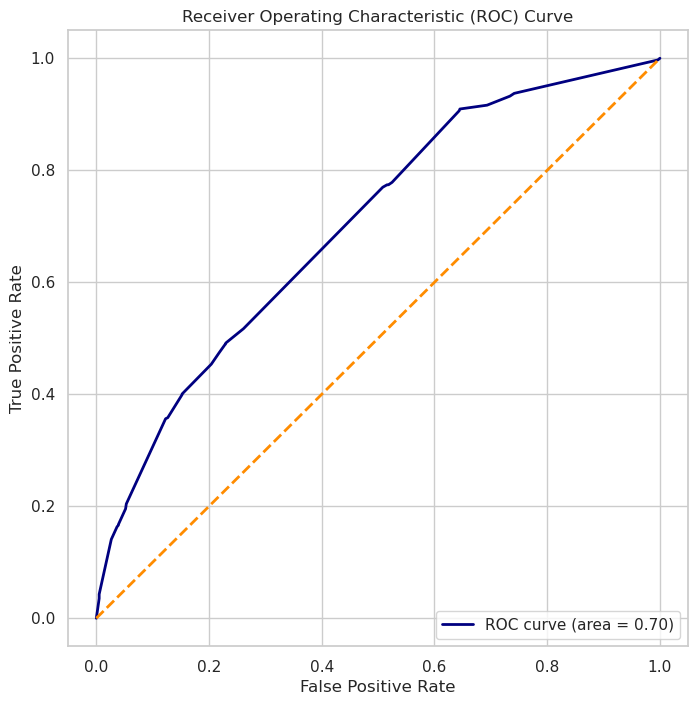

                      Feature  Coefficient
6       cs_SIGNUP_GOOGLE_AUTH     0.221130
5                   cs_SIGNUP     0.188668
0    opted_in_to_mailing_list     0.012514
3               cs_ORG_INVITE     0.011570
1  enabled_for_marketing_drip     0.011168
2                 part_of_org     0.008890
4        cs_PERSONAL_PROJECTS    -0.413009


In [8]:
X = working_df.drop('adopted', axis=1)
y = working_df['adopted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
predictions = grid_search.predict(X_test)
probabilities = grid_search.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

print(f'Best Parameters: {best_params}')
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

plt.figure(figsize=(8, 8))
sns.set(style='whitegrid')
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': grid_search.best_estimator_.coef_[0]})
print(coefficients.sort_values(by='Coefficient', ascending=False))

## conclusion and feature weights in prediction

The factor that have the most impact on adoption is the signup source.  Specifically users that signed up with their Google account or email are more likely to stay and those that were invited to personal projects are the least likely.  It surprised me that the mailing list and marketing drip had very little impact on adoption.  Also signups from members of organizations had an unexpectedly low impact.  

My recommendation would be to discard this model and return to data collection or invest more effort into exploring relationships and interactions between the individual features at a lower level.  Logistic regression has shown that there is information available in the data and shown the value of diving deeper.  However, it hasn't given a very clear picture of what that information or what an appropriate response would be.